In [1]:
%matplotlib inline

import sys

import matplotlib.pyplot as plt

import os

import matplotlib as mpl

In [4]:
from nuscenes.utils.data_classes import LidarPointCloud

from nuscenes.utils.geometry_utils import view_points
import numpy as np

from PIL import Image

from pyquaternion import Quaternion

In [2]:
sys.path.append("/home/nils/data_fusion/nuscenes-devkit/python-sdk")

In [3]:
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.3 seconds.


## Picking a random sample

In [5]:
my_sample = nusc.sample[10]

my_scene_token =my_sample['scene_token']

my_scene = nusc.get('scene', my_scene_token)

In [6]:
first_sample_token = my_scene['first_sample_token']

first_sample_from_scene = nusc.get('sample', first_sample_token)

## Picking the van in front by hand

In [8]:
vehicle_annotation_tokens = []
for i in range(len(first_sample_from_scene['anns'])):
    first_annotation_token_of_first_sample = first_sample_from_scene['anns'][i]
    if nusc.get('sample_annotation', first_annotation_token_of_first_sample)['category_name'] == 'vehicle.car':
        vehicle_annotation_tokens.append(first_annotation_token_of_first_sample)

# annotation of first frame
van_annotation_token = vehicle_annotation_tokens[7]

In [9]:
def get_lidar_pointcloud(sample_token):
    sample_record = nusc.get('sample', sample_token)
    pointsensor_channel = 'LIDAR_TOP'
    pointsensor_token = sample_record['data'][pointsensor_channel]
    pointsensor = nusc.get('sample_data', pointsensor_token)
    pcl_path = nusc.get('sample_data', pointsensor_token)['filename']
    pc =LidarPointCloud.from_file(os.path.join('nuscenes',pcl_path))
    return pointsensor_token, pc.points

In [14]:
def rotate_pointcloud(cloud, quaternion):
    def rot(an_array):
        return quaternion.rotate(an_array)
    return np.array(list(map(rot, cloud)))

In [10]:
def visualize_absolute(ax, absolute_points, ego_pose, van_translation, relativeboxvectors):
    #plt.axis('equal')
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    #axes.set_ylim([ymin,ymax])
    #ax.set(xlim=(300, 500), ylim=(1100, 1300))
    return ax.scatter(absolute_points[0], absolute_points[1], c='red', s=0.3), ax.scatter(ego_pose['translation'][0], ego_pose['translation'][1]),ax.plot([van_translation[0] + relativeboxvector[0] for relativeboxvector in relativeboxvectors], [van_translation[1] + relativeboxvector[1] for relativeboxvector in relativeboxvectors])[0]

In [12]:
def create_bounding_box(annotation_token):
    '''
    creates bounding box used for plotting
    '''
    van_annotation = nusc.get('sample_annotation', annotation_token)
    relativeboxvectors = [(van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0)]
    return np.array(relativeboxvectors), van_annotation['translation']

In [11]:
#create list of annotation tokens
current_van_annotation_token = van_annotation_token
annotation_tokens = []
while current_van_annotation_token != '':
    annotation_tokens.append(current_van_annotation_token)
    #next annotaton token
    current_van_annotation_token = nusc.get('sample_annotation', current_van_annotation_token)['next']

## Create Images

(393.6603981850444, 432.9854006128025, 1099.0106057555454, 1184.7894160060794)

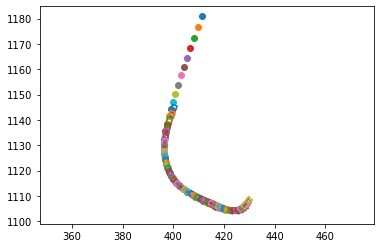

In [15]:
ims = []
fig = plt.figure()
ax = fig.add_subplot(111)  # fig and axes created once
frontimages = []

# Display points and bounding box in global coordinates over whole scene
for i,current_van_annotation_token in enumerate(annotation_tokens):

    # filter out points outside bounding box


    ## Grab the data

    van_annotation = nusc.get('sample_annotation', current_van_annotation_token)

    #get respective frame token
    sample_token = van_annotation['sample_token']

    pointsensor_token, points = get_lidar_pointcloud(sample_token)
    calibrated_sensor_token = nusc.get('sample_data', pointsensor_token)['calibrated_sensor_token']
    calibrated_sensor = nusc.get('calibrated_sensor', calibrated_sensor_token)
    ego_pose = nusc.get('ego_pose', nusc.get('sample_data', pointsensor_token)['ego_pose_token'])

    ## translate points to global reference frame

    ### Rotate points around sensor and ego rotation

    pointsensor_quaternion = Quaternion(calibrated_sensor['rotation'])
    ego_quaternion = Quaternion(ego_pose['rotation'])

    sensor_rotated_points = np.dot(pointsensor_quaternion.rotation_matrix, points[:3,:])
    rotated_points = np.dot(ego_quaternion.rotation_matrix, sensor_rotated_points)

    # use broadcasting to add translation to x and y dimension
    absolute_points = rotated_points+np.array(ego_pose['translation'][:3]).reshape(-1,1)


    ### rotate points by inverse bounding box rotation (translation to its reference frame unnecessary for only filtering)
    reverse_van_quaternion = Quaternion(w=-1*van_annotation['rotation'][0], x=van_annotation['rotation'][1], y=van_annotation['rotation'][2], z=van_annotation['rotation'][3])
    points_bounding_rotation = np.dot(reverse_van_quaternion.rotation_matrix, absolute_points)

    #new stuff
    relativeboxvectors, position = create_bounding_box(current_van_annotation_token)

    rotated_box = relativeboxvectors+reverse_van_quaternion.rotate(position)

    x_max = rotated_box[:,0].max()
    x_min = rotated_box[:,0].min()

    y_max = rotated_box[:,1].max()
    y_min = rotated_box[:,1].min()

    ## Remove points that are outside the bounding box
    mask = np.ones(points_bounding_rotation.shape[1], dtype=bool)

    mask = np.logical_and(mask, points_bounding_rotation[0] > x_min)
    mask = np.logical_and(mask, points_bounding_rotation[0] < x_max)

    mask = np.logical_and(mask, points_bounding_rotation[1] > y_min)
    mask = np.logical_and(mask, points_bounding_rotation[1] < y_max)

    points_filtered_rotated = points_bounding_rotation[:,mask]

    ### rotate points back

    van_quaternion = Quaternion(van_annotation['rotation'])
    points_filtered_absolute = np.dot(van_quaternion.rotation_matrix, points_filtered_rotated)
    # append list of plots to movie
    rotated_relativeboxvectors = rotate_pointcloud(relativeboxvectors, van_quaternion)
    plotlist = visualize_absolute(ax, points_filtered_absolute, ego_pose, van_annotation['translation'], rotated_relativeboxvectors)

    ims.append(plotlist)     

ax.axis('equal')


## Create Movie

In [16]:
ani = mpl.animation.ArtistAnimation(fig, ims, repeat=False)
ani.save('filtered_im.gif', writer='pillow')